# RK45
A notebook to test the rk45 implementation in `python`, since I don't know how to test it in `glsl`.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
# import sympy as sp

In [28]:
t0 = 0.0
t_end = 5.0

mu = 3.2
#mu2 = 21.3
def rhs(y0):
    return np.array([
        y0[1],
        mu*(1 - y0[0]*y0[0])*y0[1] - y0[0],
        0.0, #y0[2],
        0.0, #mu2*(1 - y0[2]*y0[2])*y0[3] - y0[2],
    ])

In [29]:
# Problem definition must contain this
# t0 = 0.0
# t_end = 10.0
# rrvec4 rhs(rrvec4 y0) {
#     return ...
# }

# I trust the glsl compilation to optimize const float operations away
# https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method, Formula 1
a21 = 2.0/9.0
a31 = 1.0/12.0;       a32 = 1.0/4.0
a41 = 69.0/128.0;     a42 = -243.0/128.0;   a43 = 135.0/64.0
a51 = -17.0/12.0;     a52 = 27.0/4.0;       a53 = -27.0/5.0;    a54 = 16.0/15.0
a61 = 65.0/432.0;     a62 = -5.0/16.0;      a63 = 13.0/16.0;    a64 = 4.0/27.0;     a65 = 5.0/144.0

b1 = 47.0/450.0; b2 = 0.0;  b3 = 12.0/25.0; b4 = 32.0/225.0; b5 = 1.0/30.0; b6 = 6.0/25.0
b1_ = 1.0/9.0;   b2_ = 0.0; b3_ = 9.0/20.0; b4_ = 16.0/45.0; b5_ = 1.0/12.0; b6_ = 0.0

c1 = ... # Only needed for time dependent right-hand-sides and for coefficient assertions

# Alternative coefficients from Wikipedia Formula 2
# a21 = 1.0/4.0
# a31 = 3.0/32.0;         a32 = 9.0/32.0
# a41 = 1932.0/2197.0;    a42 = -7200.0/2197.0;   a43 = 7296.0/2197.0
# a51 = ...

tau_fac_min = 1.0/3.0; tau_fac_max = 5.0 # tau_fac_max between 1.5 and 5.0 according to Numerik-Skript
tau_fac = 0.9 # tau_fac = 0.8 or 0.9 or pow(0.25, 1.0/p), where p = 5.0 in our case according to Numerik-Skript

rtol = 1e-3 # TODO should be uniform real
atol = 1e-3 # may not be 0.0 # TODO should be uniform real

MAX_STEPS = 100000    # TODO 
MAX_SAME_STEPS = 22   # TODO
MIN_TAU = 1e-8        # TODO

SUCCESS = 0
ERR_TOO_MANY_STEPS = 1
ERR_TOO_MANY_SAME_STEPS = 2
ERR_TAU_TOO_SMALL = 3

def length(v):
    return np.linalg.norm(v, 2)

def scaled_norm(vector, scale_vec):
    temp = vector / scale_vec
    return 0.5 * length(temp) # length is 2-norm

def explicit_euler(y0, n):
    ys = [y0]
    ts = [t0]

    tau = (t_end - t0) / n

    y = y0
    n = 1
    while t0 + n*tau < t_end - 1e-9:
        y = y + tau*rhs(y)

        ts.append(t0 + n*tau)
        ys.append(y)

        n += 1
    
    return y, ts, ys

def rk5(y0, n):
    ys = [y0]
    ts = [t0]

    tau = (t_end - t0) / n

    y = y0
    n = 1
    while t0 + n*tau < t_end - 1e-9:
        Y1 = y
        Z1 = rhs(Y1)

        Y2 = y + tau*(a21*Z1)
        Z2 = rhs(Y2)

        Y3 = y + tau*(a31*Z1 + a32*Z2)
        Z3 = rhs(Y3)

        Y4 = y + tau*(a41*Z1 + a42*Z2 + a43*Z3)
        Z4 = rhs(Y4)

        Y5 = y + tau*(a51*Z1 + a52*Z2 + a53*Z3 + a54*Z4)
        Z5 = rhs(Y5)

        Y6 = y + tau*(a61*Z1 + a62*Z2 + a63*Z3 + a64*Z4 + a65*Z5)
        Z6 = rhs(Y6)

        y = y + tau*(b1*Z1 + b2*Z2 + b3*Z3 + b4*Z4 + b5*Z5 + b6*Z6)

        ts.append(t0 + n*tau)
        ys.append(y)

        n += 1
    
    return y, ts, ys

def rk4(y0, n):
    ys = [y0]
    ts = [t0]

    tau = (t_end - t0) / n

    y = y0
    n = 1
    while t0 + n*tau < t_end - 1e-9:
        Y1 = y
        Z1 = rhs(Y1)

        Y2 = y + tau*(a21*Z1)
        Z2 = rhs(Y2)

        Y3 = y + tau*(a31*Z1 + a32*Z2)
        Z3 = rhs(Y3)

        Y4 = y + tau*(a41*Z1 + a42*Z2 + a43*Z3)
        Z4 = rhs(Y4)

        Y5 = y + tau*(a51*Z1 + a52*Z2 + a53*Z3 + a54*Z4)
        Z5 = rhs(Y5)

        Y6 = y + tau*(a61*Z1 + a62*Z2 + a63*Z3 + a64*Z4 + a65*Z5)
        Z6 = rhs(Y6)

        y = y + tau*(b1_*Z1 + b2_*Z2 + b3_*Z3 + b4_*Z4 + b5_*Z5 + b6_*Z6)

        ts.append(t0 + n*tau)
        ys.append(y)

        n += 1
    
    return y, ts, ys


def rk45_step(y0, tau):
    Y1 = y0
    Z1 = rhs(Y1)

    Y2 = y0 + tau*(a21*Z1)
    Z2 = rhs(Y2)

    Y3 = y0 + tau*(a31*Z1 + a32*Z2)
    Z3 = rhs(Y3)

    Y4 = y0 + tau*(a41*Z1 + a42*Z2 + a43*Z3)
    Z4 = rhs(Y4)

    Y5 = y0 + tau*(a51*Z1 + a52*Z2 + a53*Z3 + a54*Z4)
    Z5 = rhs(Y5)

    Y6 = y0 + tau*(a61*Z1 + a62*Z2 + a63*Z3 + a64*Z4 + a65*Z5)
    Z6 = rhs(Y6)

    y1 = y0 + tau*(b1*Z1 + b2*Z2 + b3*Z3 + b4*Z4 + b5*Z5 + b6*Z6)
    err_vec = tau*((b1 - b1_)*Z1 + (b2 - b2_)*Z2 + (b3 - b3_)*Z3 + (b4 - b4_)*Z4 + (b5 - b5_)*Z5 + (b6 - b6_)*Z6)


    # Error estimation and Calculation of optimal tau
    scale_vec = np.maximum(np.abs(y0), np.abs(y1))*rtol + atol
    err = scaled_norm(err_vec, scale_vec)
    out_tau = tau * np.minimum(tau_fac_max, np.maximum(tau_fac_min, tau_fac*pow(1.0 / np.maximum(err, 1e-10), 1.0/5.0))) # np.maximum(err, 1e-10) to prevent division by zero

    if err >= 1.0:
        return y0, out_tau, False

    return y1, out_tau, True

def rk45(y0):
    # Guess initial step size (according to ChatGPT)
    z0 = rhs(y0)
    y0_norm = scaled_norm(y0, np.abs(y0)*rtol + atol)
    z0_norm = scaled_norm(z0, np.abs(z0)*rtol + atol)
    tau = 0.01 * y0_norm / np.maximum(z0_norm, 1e-10) # prevent divide by 0.0
    tau = np.minimum(1.0, np.maximum(1e-8, tau)) # clamp to range [1e-8, 1.0]

    step_counter = 0
    same_step_counter = 0
    t = t0
    y = y0
    ts = [t0]
    ys = [y0]
    while t < t_end - 1e-9: # small tolerance to rounding errors
        if step_counter >= MAX_STEPS:
            return None, ERR_TOO_MANY_STEPS, step_counter, same_step_counter, ts, ys
        
        if same_step_counter >= MAX_SAME_STEPS:
            return None, ERR_TOO_MANY_SAME_STEPS, step_counter, same_step_counter, ts, ys
        
        if tau < MIN_TAU and t + tau < t_end - 1e-9: # tau too small and not close to end
            error_code = ERR_TAU_TOO_SMALL
            return None, ERR_TAU_TOO_SMALL, step_counter, same_step_counter, ts, ys
        

        used_tau = np.minimum(tau, t_end - t) # make sure not to overshoot t_end
        y, tau, isAccepted = rk45_step(y, used_tau) # tau is always updated to new step size. On success next y is returned, otherwise the initial y

        if isAccepted:
            same_step_counter = 0
            t += used_tau
            ts.append(t)
            ys.append(y)
        else:
            same_step_counter += 1

        step_counter += 1

    return y, SUCCESS, step_counter, same_step_counter, ts, ys



In [30]:
# Check Coefficients
assert np.abs(b1 + b2 + b3 + b4 + b5 + b6 - 1.0) < 1e-8
assert np.abs(b1_ + b2_ + b3_ + b4_ + b5_ + b6_ - 1.0) < 1e-8
#assert np.abs()

In [51]:

def plot_solution(ts, ys):
    fig, ax = plt.subplots(figsize=(7, 7))

    ref_sol = scipy.integrate.solve_ivp(lambda t, y: rhs(y), t_span=(t0, t_end), y0=y0, atol=atol, rtol=rtol)
    print(f"RK45 Reference Solver, steps={len(ref_sol.t)}")

    linear_ts = np.linspace(ts[0], ts[-1], 200)
    exact_sol = scipy.integrate.solve_ivp(lambda t, y: rhs(y), t_span=(t0, t_end), y0=y0, atol=3e-14, rtol=3e-14, t_eval=linear_ts)
    
    ax.plot(ts, np.array(ys)[:, 0:2], marker = 'o', label = 'RK45 solution')
    ax.plot(ref_sol.t, ref_sol.y[0:2, :].T, color = 'gray', marker = 'x', label = 'Reference RK45 solution')
    ax.plot(exact_sol.t, exact_sol.y[0:2, :].T, color = 'gray', linestyle = 'dotted', label = 'Exact solution (high accuracy)')
    ax.legend()
    fig.show()

Success, total_steps=32, same_step_counter=0
RK45 Reference Solver, steps=22


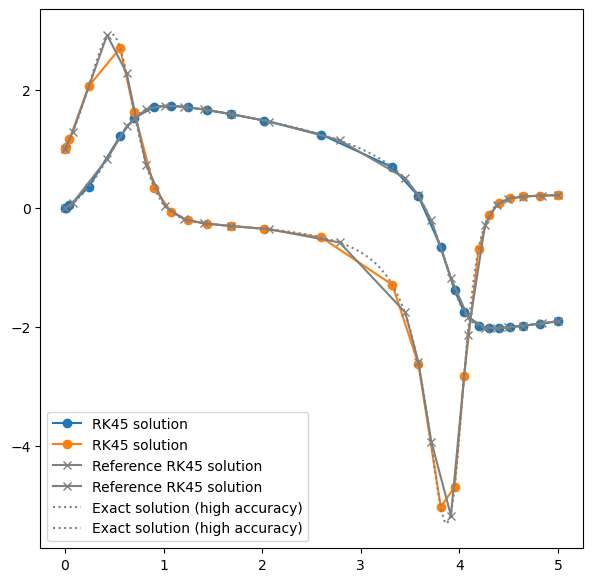

In [ ]:
y0 = np.array([0.0, 1.0, 1.0, 0.0])

y_end, status, total_steps, same_step_counter, ts, ys = rk45(y0)

if status == SUCCESS:
    print(f"Success, total_steps={total_steps}, same_step_counter={same_step_counter}")
elif status == ERR_TAU_TOO_SMALL:
    print(f"Error tau too small, total_steps={total_steps}, same_step_counter={same_step_counter}")
elif status == ERR_TOO_MANY_STEPS:
    print(f"Error too many steps, total_steps={total_steps}, same_step_counter={same_step_counter}")
elif status == ERR_TOO_MANY_SAME_STEPS:
    print(f"Error too many SAME steps, total_steps={total_steps}, same_step_counter={same_step_counter}")

plot_solution(ts, ys)

Done with n=30.0, error5=0.016929331968869143, error4=0.07432206060912361
Done with n=68.7911395962113, error5=0.00016263008986028282, error4=0.0004825228682487914
Done with n=157.74069623151425, error5=1.800018499142908e-06, error4=2.2280905917160254e-05
Done with n=361.7054084821888, error5=2.3583589303655117e-08, error4=9.75671471614703e-07
Done with n=829.4042415867622, error5=3.3974645319290175e-10, error4=3.754183719451021e-08
Done with n=1901.8554321561564, error5=1.2583711850311374e-11, error4=1.3894005945758181e-09
Done with n=4361.026750842233, error5=7.599254558954271e-12, error4=5.24860155337592e-11
Done with n=10000.0, error5=8.782308213994838e-12, error4=6.944667063635279e-12


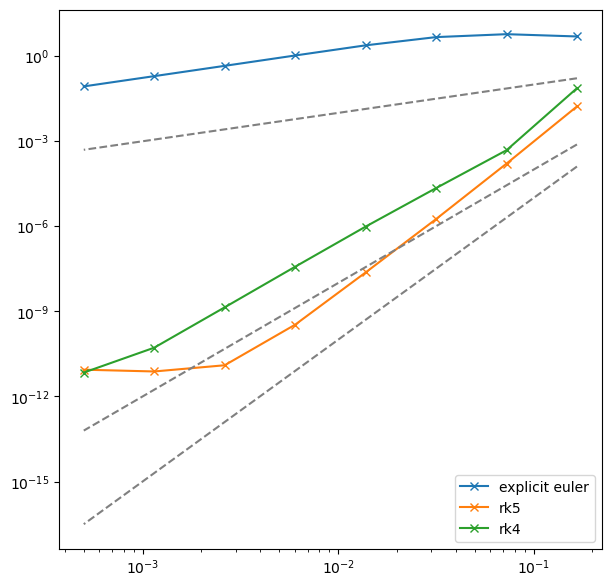

In [34]:

ns = np.geomspace(30, 1e4, num=8)
taus = (t_end - t0) / ns
errorsee = []
errors5 = []
errors4 = []


for n in ns:
    _, tsee, ysee = explicit_euler(y0, n)
    _, ts5, ys5 = rk5(y0, n)
    _, ts4, ys4 = rk4(y0, n)

    # plot_solution(ts5, ys5)

    assert np.all(ts5 == ts4)
    exact_sol = scipy.integrate.solve_ivp(lambda t, y: rhs(y), t_span=(t0, t_end), y0=y0, atol=3e-14, rtol=3e-14, t_eval=ts5)

    errorsee.append(np.max(np.abs(ysee - exact_sol.y.T)))
    errors5.append(np.max(np.abs(ys5 - exact_sol.y.T)))
    errors4.append(np.max(np.abs(ys4 - exact_sol.y.T)))
    print(f'Done with n={n}, error5={errors5[-1]}, error4={errors4[-1]}')


fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(taus, np.array(errorsee), marker = 'x', label = 'explicit euler')
ax.plot(taus, np.array(errors5), marker = 'x', label = 'rk5')
ax.plot(taus, np.array(errors4), marker = 'x', label = 'rk4')

ax.plot(taus, taus**1, color='gray', linestyle = 'dashed')
ax.plot(taus, taus**5, color='gray', linestyle = 'dashed')
ax.plot(taus, taus**4, color='gray', linestyle = 'dashed')

ax.legend()
fig.show()